In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from find_screen_utils import *
from __future__ import division
import warnings
from sklearn import linear_model

##Template Matching

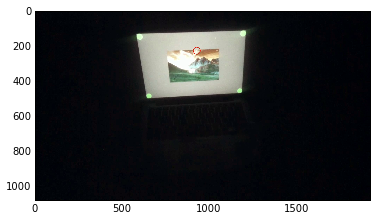

In [12]:
img = cv2.imread('images/tobii/border/frames/dark_dots/frame200.bmp')
plt.imshow(img);

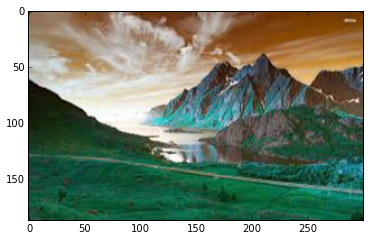

In [13]:
temp = cv2.imread('images/display/1.jpeg')
ratio = (temp.shape[1]/temp.shape[0])/(16/10)
temp = cv2.resize(temp, (temp.shape[1], int(temp.shape[0]*ratio)))
plt.imshow(temp);

In [14]:
res = cv2.matchTemplate(img, temp, cv2.cv.CV_TM_SQDIFF)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
match_loc = min_loc

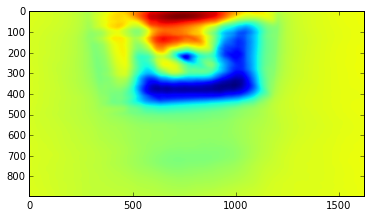

In [15]:
plt.imshow(res);

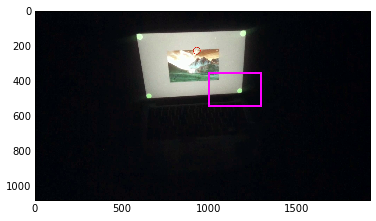

In [16]:
found = img.copy()
rect_pt = (match_loc[0]+temp.shape[1], match_loc[1]+temp.shape[0])
cv2.rectangle(found, match_loc, rect_pt, (255,0,255), 10)
plt.imshow(found);

##Feature Matching

In [106]:
def drawMatches(img1, kp1, img2, kp2, matches, mask):
    """
    My own implementation of cv2.drawMatches as OpenCV 2.4.9
    does not have this function available but it's supported in
    OpenCV 3.0.0

    This function takes in two images with their associated 
    keypoints, as well as a list of DMatch data structure (matches) 
    that contains which keypoints matched in which images.

    An image will be produced where a montage is shown with
    the first image followed by the second image beside it.

    Keypoints are delineated with circles, while lines are connected
    between matching keypoints.

    img1,img2 - Grayscale images
    kp1,kp2 - Detected list of keypoints through any of the OpenCV keypoint 
              detection algorithms
    matches - A list of matches of corresponding keypoints through any
              OpenCV keypoint matching algorithm
    """

    # Create a new output image that concatenates the two images together
    # (a.k.a) a montage
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    out[:rows1,:cols1] = np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2,cols1:] = np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    i = 0
    for mat in matches:
        if mask[i] == 0:
            i += 1
            continue
        i += 1
        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        # Draw a small circle at both co-ordinates
        # radius 4
        # colour green
        # thickness = 1
        cv2.circle(out, (int(x1),int(y1)), 4, (0, 255, 0), 1)   
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (0, 255, 0), 1)

        # Draw a line in between the two points
        # thickness = 1
        # colour green
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (0, 255, 0), 3)

    # Also return the image if you'd like a copy
    return out

In [127]:
img1 = cv2.imread('images/feature_matching/match.jpeg', 0)
img2 = cv2.imread('images/feature_matching/frames/frame500.bmp', 0)
MIN_MATCH_COUNT = 3

In [128]:
sift = cv2.SIFT()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

In [129]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [130]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    cv2.polylines(img2,[np.int32(dst)],True,255,3)

else:
    print "Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT)
    matchesMask = None

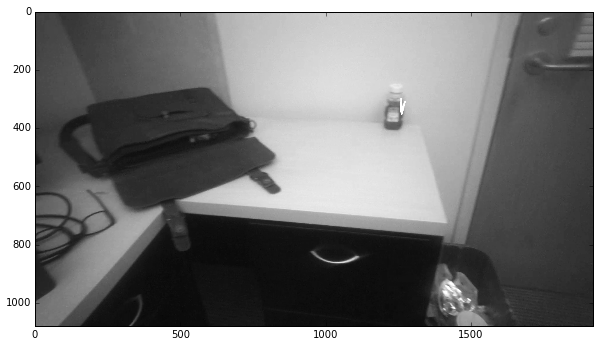

In [131]:
plt.figure(figsize=(10,10))
plt.imshow(img2, 'gray');

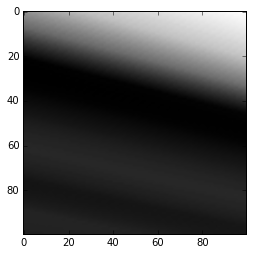

In [132]:
plt.imshow(cv2.warpPerspective(img1.astype('float32'), M.astype('float32'), (100,100)), "gray")

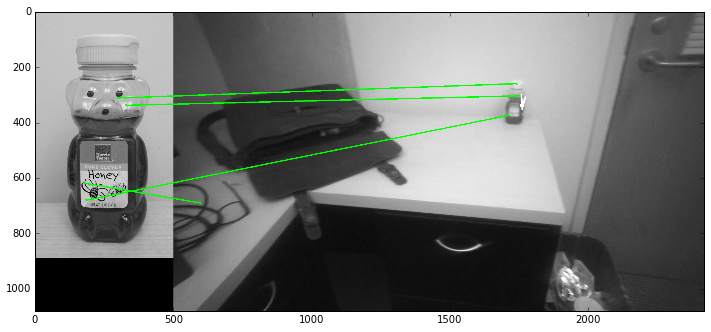

In [133]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = drawMatches(img1,kp1,img2,kp2,good, matchesMask)
plt.figure(figsize=(12,12))
plt.imshow(img3);